In [69]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rich.console import Console
from rich.progress import track

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Set a global Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid", context="talk")

# Initialize Console for logging
console = Console()


In [70]:
# Define dataset folder paths
base_path = r"D:\Semester 6\Data Science\Ass 2\Ass2\dataset"
electricity_folder = os.path.join(base_path, "electricity_raw_data")
weather_folder = os.path.join(base_path, "weather_raw_data")

# ------------------ Load Electricity Demand Data (JSON) ------------------ #
console.print("[yellow]Loading Electricity Data...[/yellow]")
electricity_files = glob.glob(os.path.join(electricity_folder, "*.json"))
electricity_dataframes = []

for file in track(electricity_files, description="Processing electricity data..."):
    try:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
        
        # Validate JSON structure and extract data
        if "response" in data and "data" in data["response"]:
            df = pd.DataFrame(data["response"]["data"])
            # Check if expected columns exist
            if 'period' in df.columns and 'value' in df.columns:
                df.rename(columns={'period': 'timestamp', 'value': 'electricity_demand'}, inplace=True)
                # Parse timestamp and localize
                df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H", errors='coerce').dt.tz_localize("UTC")
                df['electricity_demand'] = pd.to_numeric(df['electricity_demand'], errors='coerce')
                df.dropna(subset=['timestamp'], inplace=True)
                electricity_dataframes.append(df)
            else:
                console.print(f"[red]⚠ Skipping {file} (Missing 'period' or 'value' columns)[/red]")
        else:
            console.print(f"[red]⚠ Skipping {file} (Incorrect JSON structure)[/red]")
    except Exception as e:
        console.print(f"[red] Error processing {file}: {e}[/red]")

electricity_df = pd.concat(electricity_dataframes, ignore_index=True) if electricity_dataframes else pd.DataFrame()
console.print(f"[green] Loaded {len(electricity_df)} records from electricity data[/green]")

# ------------------ Load Weather Data (CSV) ------------------ #
console.print("[yellow]Loading Weather Data...[/yellow]")
weather_files = glob.glob(os.path.join(weather_folder, "*.csv"))
weather_dataframes = []

for file in track(weather_files, description="Processing weather data..."):
    df = pd.read_csv(file, encoding="utf-8")
    weather_dataframes.append(df)

weather_df = pd.concat(weather_dataframes, ignore_index=True) if weather_dataframes else pd.DataFrame()
weather_df.rename(columns={'date': 'timestamp'}, inplace=True)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], errors='coerce')
weather_df.dropna(subset=['timestamp'], inplace=True)
console.print("[green] Weather Data Processed Successfully![/green]")


Loading Electricity Data...

Output()

 Loaded 301642 records from electricity data

Loading Weather Data...

Output()

 Weather Data Processed Successfully!

In [71]:
console.print("[yellow]Ensuring timestamps are in the same format...[/yellow]")
if 'timestamp' in electricity_df.columns:
    electricity_df['timestamp'] = electricity_df['timestamp'].dt.tz_localize(None)
if 'timestamp' in weather_df.columns:
    weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)
console.print("[green] Timestamp formats fixed![/green]")

console.print("[yellow]Merging Electricity & Weather Data...[/yellow]")
merged_df = pd.merge(electricity_df, weather_df, on="timestamp", how="inner")
console.print("[cyan] Data Merged Successfully![/cyan]")

# Add processing timestamp
merged_df['processed_at'] = pd.Timestamp.now()


Ensuring timestamps are in the same format...

 Timestamp formats fixed!

Merging Electricity & Weather Data...

 Data Merged Successfully!

In [72]:
console.rule("[bold blue]Missing Data Analysis[/bold blue]")
missing_counts = merged_df.isnull().sum()
missing_percentage = (merged_df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({"Missing Count": missing_counts, "Missing Percentage": missing_percentage})
console.print(missing_df)


────────────────────────────────────────────── Missing Data Analysis ──────────────────────────────────────────────

Missing Count  Missing Percentage
timestamp                       0                 0.0
subba                           0                 0.0
subba-name                      0                 0.0
parent                          0                 0.0
parent-name                     0                 0.0
electricity_demand              0                 0.0
value-units                     0                 0.0
temperature_2m                  0                 0.0
processed_at                    0                 0.0

In [73]:
console.rule("[bold blue]Step 2: Data Preprocessing[/bold blue]")

# Forward-fill missing values and remove duplicates
merged_df.ffill(inplace=True)
merged_df.drop_duplicates(inplace=True)

# Feature Engineering: Extract time-based features
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

console.print("[green] Data Preprocessed Successfully![/green]")


─────────────────────────────────────────── Step 2: Data Preprocessing ────────────────────────────────────────────

 Data Preprocessed Successfully!

───────────────────────────────────── Step 3: Exploratory Data Analysis (EDA) ─────────────────────────────────────

timestamp  electricity_demand  temperature_2m  \
count                         289531       289531.000000   289531.000000   
mean   2023-07-03 13:28:18.309334272         1556.937606       11.346059   
min              2022-01-01 05:00:00          168.000000      -10.491500   
25%              2022-10-02 09:00:00          696.000000        5.008500   
50%              2023-07-03 13:00:00         1120.000000       10.808500   
75%              2024-04-02 18:00:00         1725.000000       17.408500   
max              2025-01-02 00:00:00        10830.000000       37.708500   
std                              NaN         1455.568629        8.095719   

                     processed_at           hour            day  \
count                      289531  289531.000000  289531.000000   
mean   2025-02-28 21:53:51.274639      11.502223      15.721857   
min    2025-02-28 21:53:51.274639       0.000000       1.000000   
25%    2025-02-28 21:53:51.274639       6.000000       8.000000   
50%    2025-02-28 21:53:51.274639      12.000000      16.000000   
75%    2025-02-28 21:53:51.274639      18.000000      23.000000   
max    2025-02-28 21:53:51.274639      23.000000      31.000000   
std                           NaN       6.921747       8.807689   

               month    day_of_week     is_weekend  
count  289531.000000  289531.000000  289531.000000  
mean        6.517648       2.998708       0.286121  
min         1.000000       0.000000       0.000000  
25%         4.000000       1.000000       0.000000  
50%         7.000000       3.000000       0.000000  
75%        10.000000       5.000000       1.000000  
max        12.000000       6.000000       1.000000  
std         3.450933       2.001674       0.451948

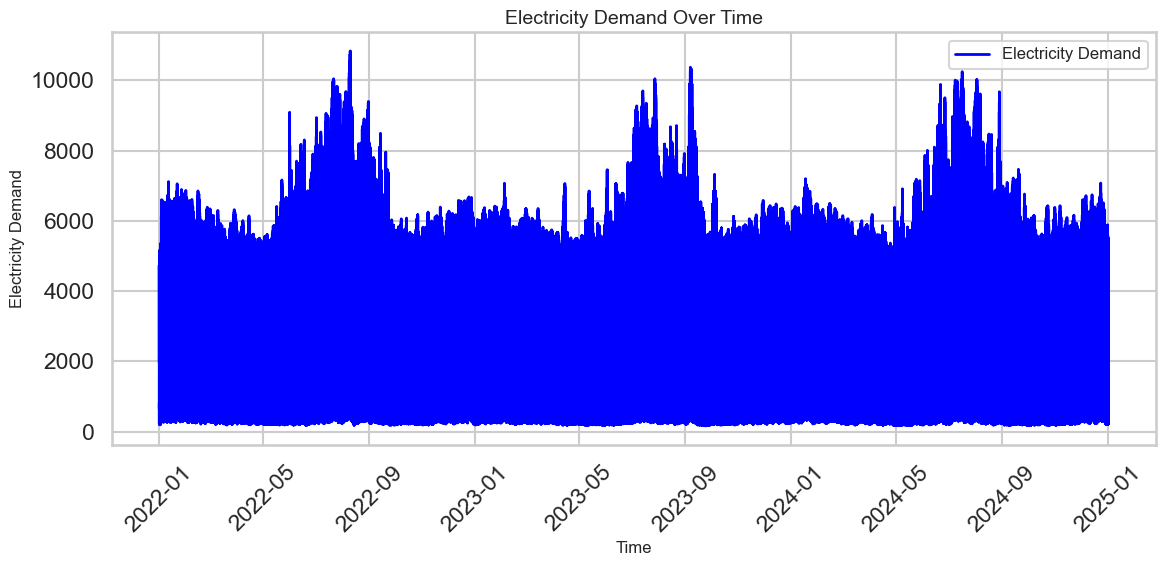

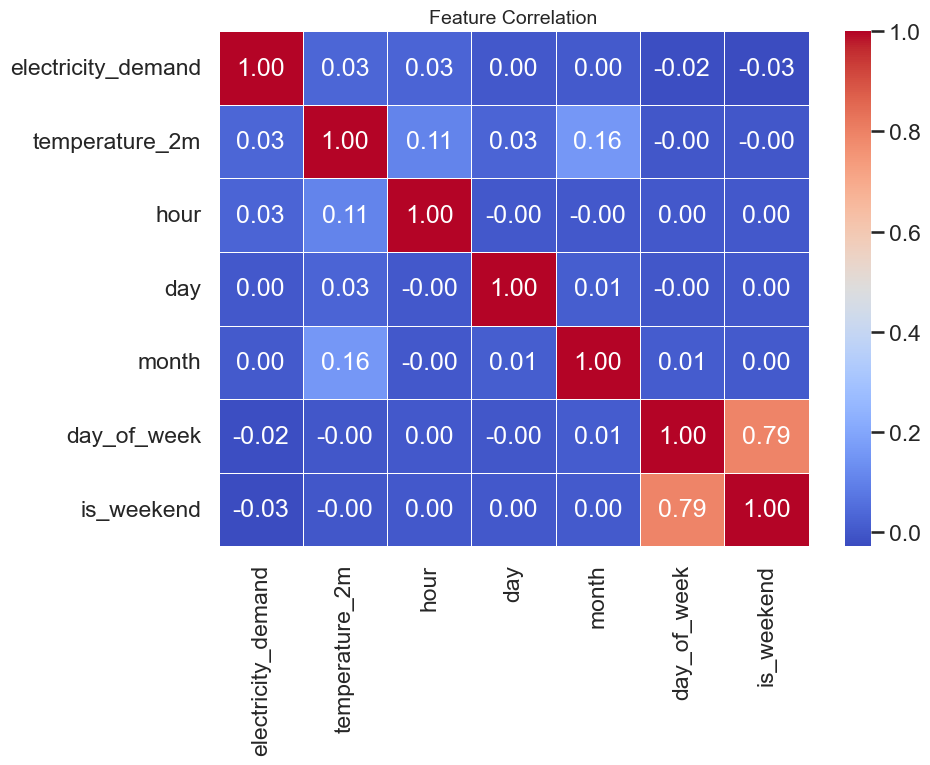

In [74]:
console.rule("[bold blue]Step 3: Exploratory Data Analysis (EDA)[/bold blue]")

# Print summary statistics
console.print(merged_df.describe())

# Electricity Demand Over Time Plot
plt.figure(figsize=(12,6))
plt.plot(merged_df['timestamp'], merged_df['electricity_demand'], label="Electricity Demand", color="blue", linewidth=2)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Electricity Demand", fontsize=12)
plt.title("Electricity Demand Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Correlation Heatmap (using numeric columns)
plt.figure(figsize=(10,8))
numeric_df = merged_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Feature Correlation", fontsize=14)
plt.tight_layout()
plt.show()


────────────────────────────────────────── Advanced Time Series Analysis ──────────────────────────────────────────

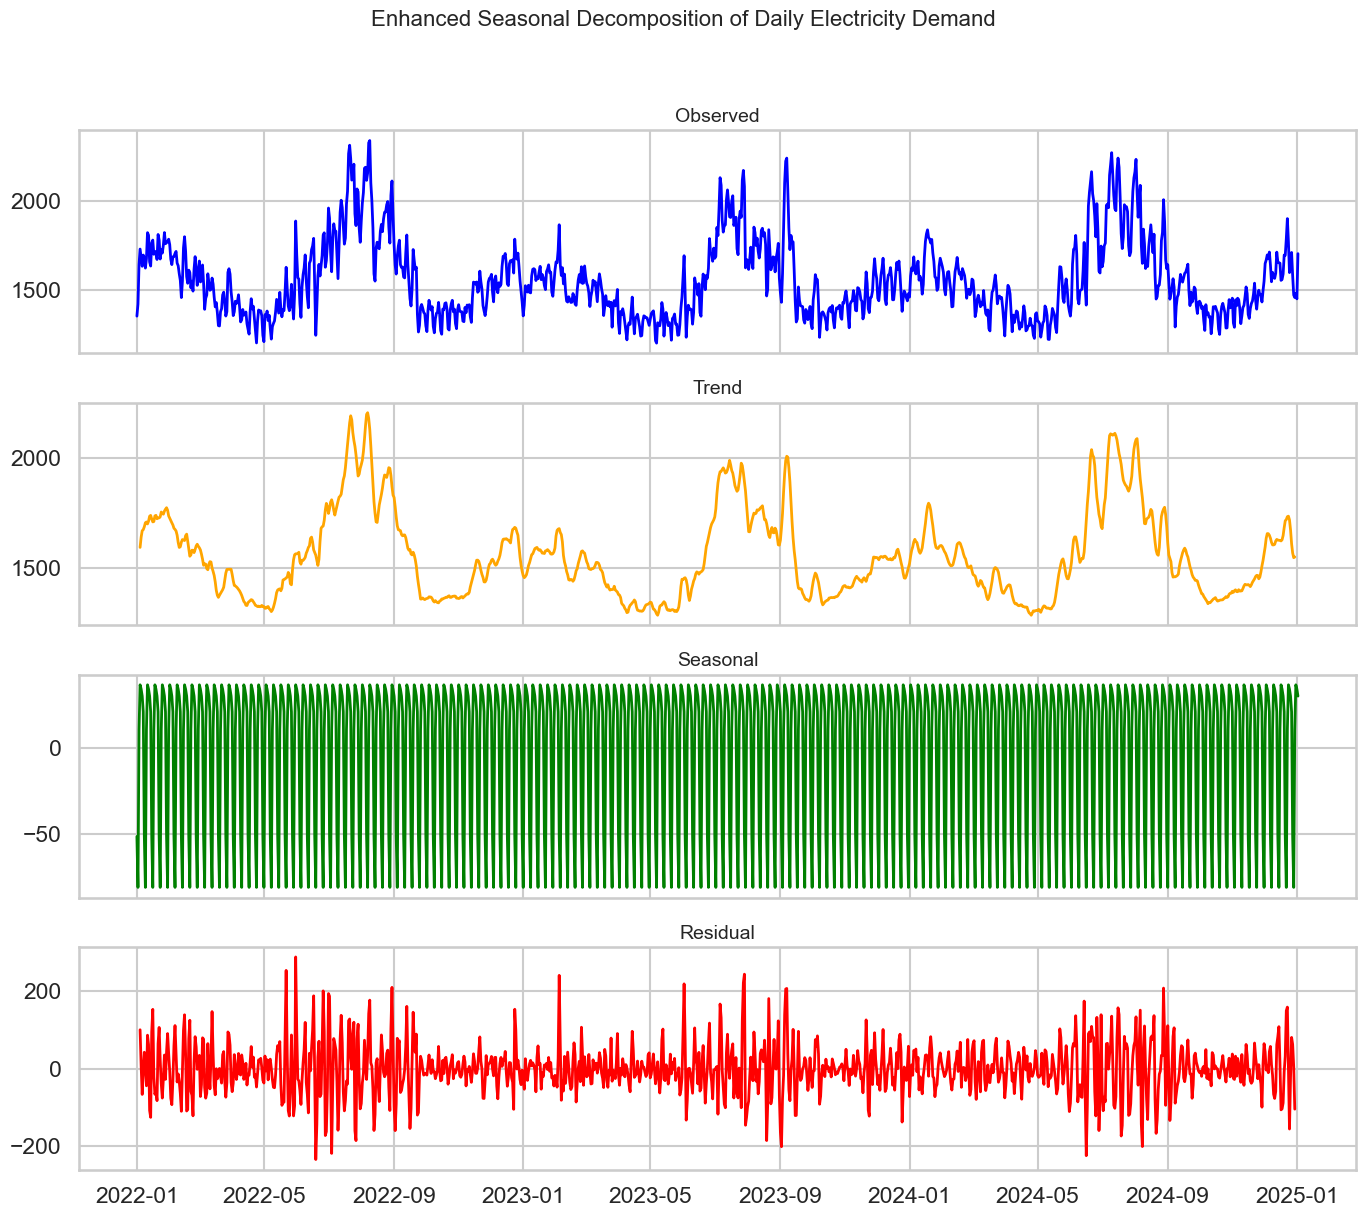

Augmented Dickey-Fuller Test

ADF Statistic: -3.2690

p-value: 0.0163

The time series is likely stationary.

In [75]:
console.rule("[bold blue]Advanced Time Series Analysis[/bold blue]")

# Resample daily demand from the merged dataset
daily_demand = merged_df.set_index('timestamp')['electricity_demand'].resample('D').mean().dropna()

# Enhanced seasonal decomposition using subplots
decomposition = seasonal_decompose(daily_demand, model='additive', period=7)
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Observed
axes[0].plot(daily_demand.index, daily_demand, color='blue', lw=2)
axes[0].set_title('Observed', fontsize=14)
axes[0].grid(True)
# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, color='orange', lw=2)
axes[1].set_title('Trend', fontsize=14)
axes[1].grid(True)
# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, color='green', lw=2)
axes[2].set_title('Seasonal', fontsize=14)
axes[2].grid(True)
# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid, color='red', lw=2)
axes[3].set_title('Residual', fontsize=14)
axes[3].grid(True)

plt.suptitle("Enhanced Seasonal Decomposition of Daily Electricity Demand", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(daily_demand)
console.print("[bold blue]Augmented Dickey-Fuller Test[/bold blue]")
console.print(f"ADF Statistic: {adf_result[0]:.4f}")
console.print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    console.print("[green]The time series is likely stationary.[/green]")
else:
    console.print("[red]The time series is likely non-stationary.[/red]")


───────────────────────────────────── Step 4: Outlier Detection and Handling ──────────────────────────────────────

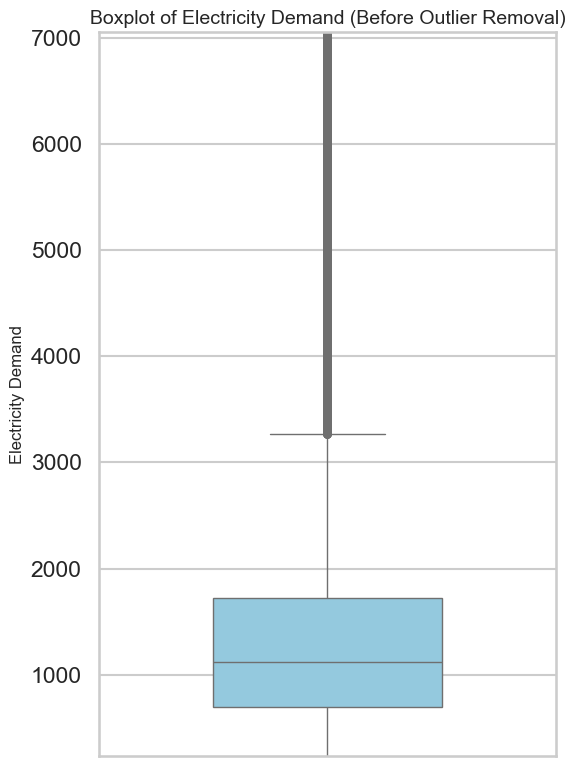

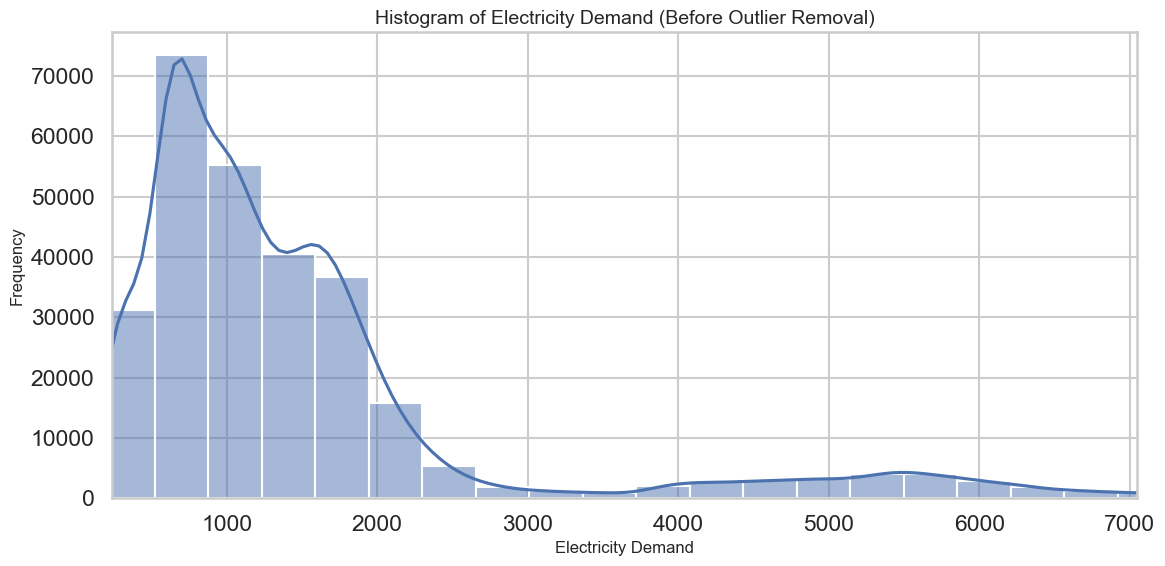

 Outliers Handled Successfully!

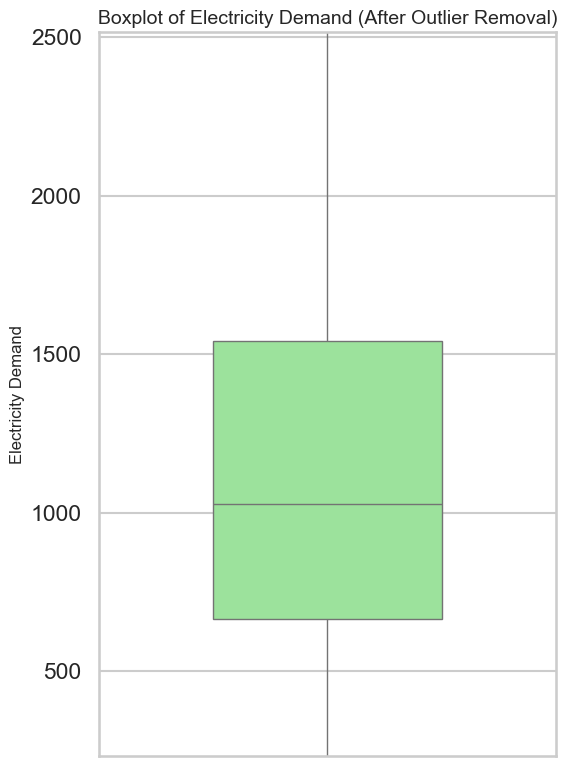

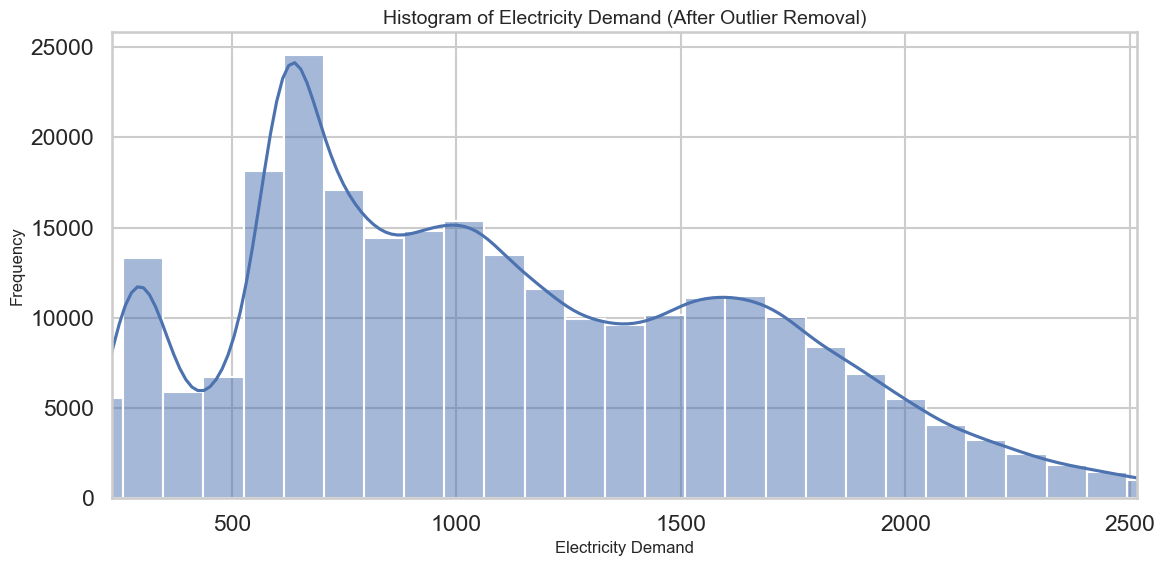

In [76]:
console.rule("[bold blue]Step 4: Outlier Detection and Handling[/bold blue]")

# Visualize distribution BEFORE outlier removal with enhanced vertical box plot
plt.figure(figsize=(6,8))
sns.boxplot(y=merged_df['electricity_demand'], color='skyblue', fliersize=5, width=0.5)
plt.title("Boxplot of Electricity Demand (Before Outlier Removal)", fontsize=14)
plt.ylabel("Electricity Demand", fontsize=12)
plt.ylim(merged_df['electricity_demand'].quantile(0.01), merged_df['electricity_demand'].quantile(0.99))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(merged_df['electricity_demand'], bins=30, kde=True)
plt.title("Histogram of Electricity Demand (Before Outlier Removal)", fontsize=14)
plt.xlabel("Electricity Demand", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(merged_df['electricity_demand'].quantile(0.01), merged_df['electricity_demand'].quantile(0.99))
plt.tight_layout()
plt.show()

# IQR-based Outlier Detection
Q1 = merged_df['electricity_demand'].quantile(0.25)
Q3 = merged_df['electricity_demand'].quantile(0.75)
IQR = Q3 - Q1
merged_df = merged_df[(merged_df['electricity_demand'] >= Q1 - 1.5 * IQR) &
                      (merged_df['electricity_demand'] <= Q3 + 1.5 * IQR)]

# Recompute numeric dataframe after IQR filtering and apply Z-score filtering
numeric_df = merged_df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(numeric_df))
merged_df = merged_df[(z_scores < 3).all(axis=1)]

console.print("[green] Outliers Handled Successfully![/green]")

# Visualize distribution AFTER outlier removal with enhanced vertical box plot
plt.figure(figsize=(6,8))
sns.boxplot(y=merged_df['electricity_demand'], color='lightgreen', fliersize=5, width=0.5)
plt.title("Boxplot of Electricity Demand (After Outlier Removal)", fontsize=14)
plt.ylabel("Electricity Demand", fontsize=12)
plt.ylim(merged_df['electricity_demand'].quantile(0.01), merged_df['electricity_demand'].quantile(0.99))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(merged_df['electricity_demand'], bins=30, kde=True)
plt.title("Histogram of Electricity Demand (After Outlier Removal)", fontsize=14)
plt.xlabel("Electricity Demand", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(merged_df['electricity_demand'].quantile(0.01), merged_df['electricity_demand'].quantile(0.99))
plt.tight_layout()
plt.show()


─────────────────────────────────────────── Step 5: Regression Modeling ───────────────────────────────────────────

Model Trained! MSE: 309303.87, RMSE: 556.15, R² Score: 0.0015

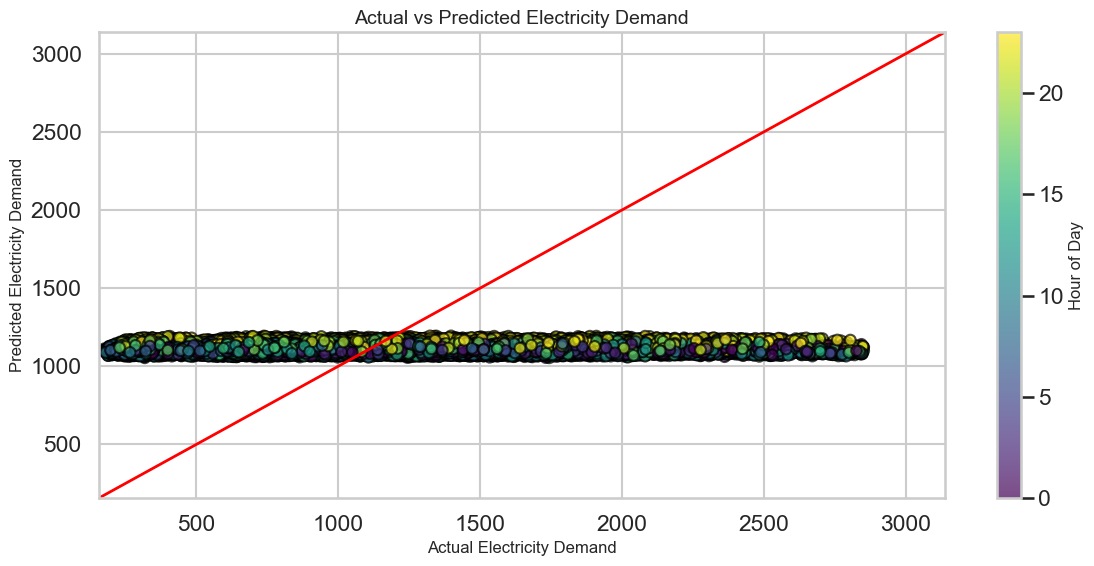

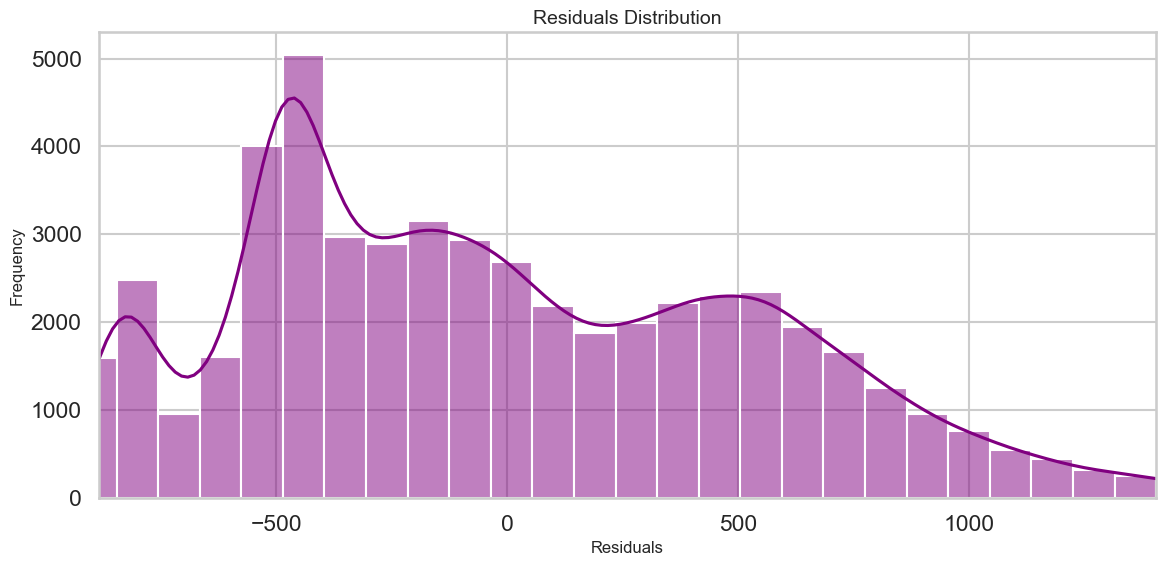

In [64]:
console.rule("[bold blue]Step 5: Regression Modeling[/bold blue]")

# Check if temperature column exists
if 'temperature_2m' not in merged_df.columns:
    console.print("[red] ERROR: 'temperature_2m' column is missing from weather data![/red]")
    raise KeyError("Missing 'temperature_2m' column")

X = merged_df[['hour', 'day', 'month', 'temperature_2m']]
y = merged_df['electricity_demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
console.print(f"Model Trained! MSE: {mse:.2f}, RMSE: {rmse:.2f}, R² Score: {r2:.4f}")

# Enhanced Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(12,6))
scatter = plt.scatter(
    y_test,
    y_pred,
    c=X_test['hour'],        
    cmap='viridis',
    alpha=0.7,
    s=60,
    edgecolors='black'
)
cbar = plt.colorbar(scatter)
cbar.set_label('Hour of Day', fontsize=12)
min_val = min(y_test.min(), y_pred.min()) * 0.9
max_val = max(y_test.max(), y_pred.max()) * 1.1
plt.plot([min_val, max_val], [min_val, max_val], color="red", lw=2)
plt.xlabel("Actual Electricity Demand", fontsize=12)
plt.ylabel("Predicted Electricity Demand", fontsize=12)
plt.title("Actual vs Predicted Electricity Demand", fontsize=14)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(12,6))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Residuals Distribution", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(residuals.quantile(0.01), residuals.quantile(0.99))
plt.tight_layout()
plt.show()


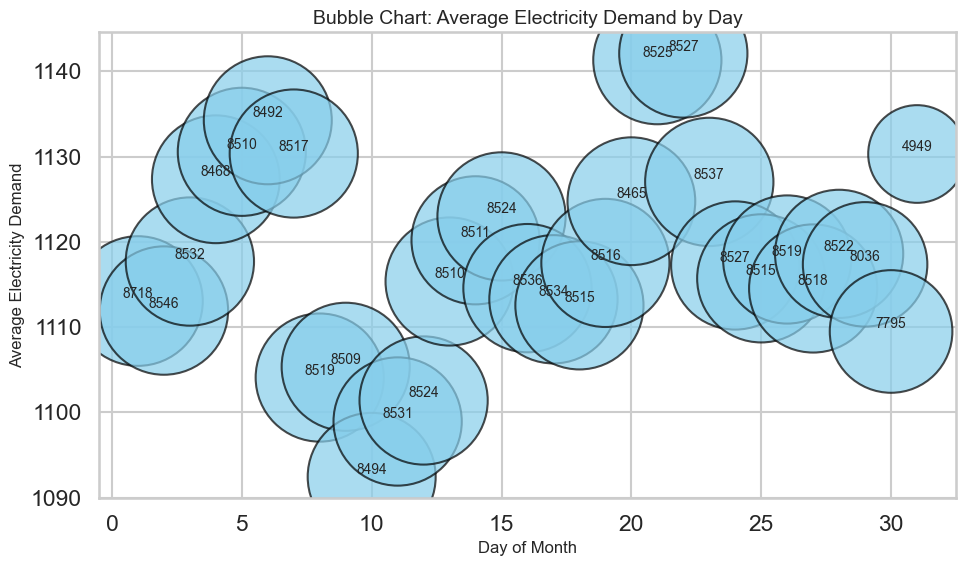

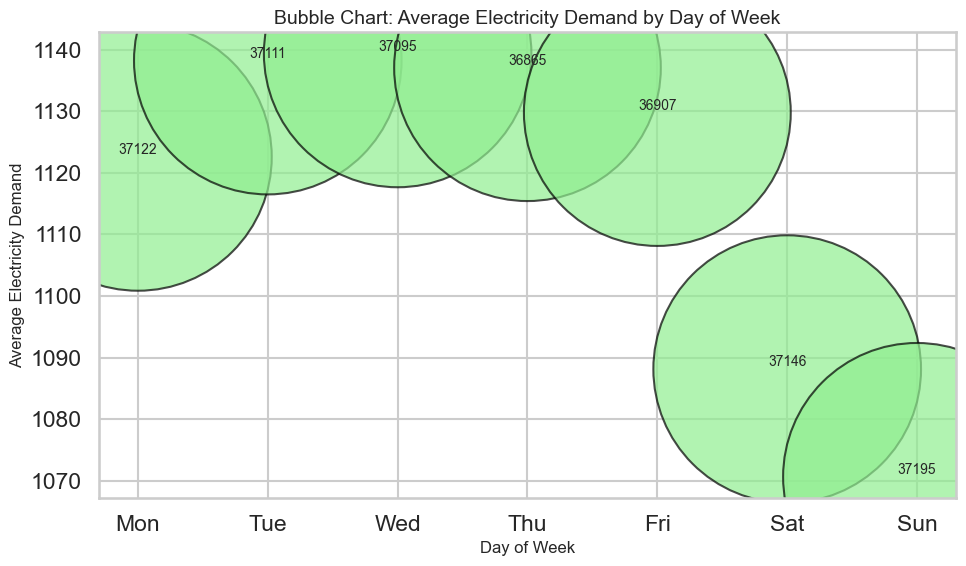

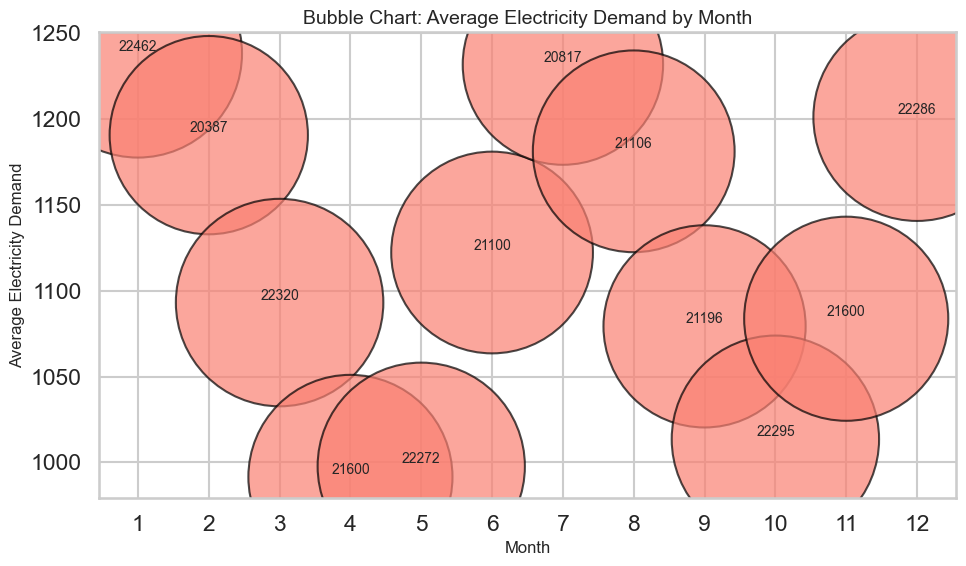

In [77]:
# Bubble Chart for Day: Average Electricity Demand by Day of Month
day_group = merged_df.groupby('day').agg({
    'electricity_demand': 'mean',
    'temperature_2m': 'mean',
    'timestamp': 'count'
}).reset_index()
day_group.rename(columns={'timestamp': 'count'}, inplace=True)

plt.figure(figsize=(10,6))
plt.scatter(day_group['day'], day_group['electricity_demand'], s=day_group['count']*1, 
            alpha=0.7, color='skyblue', edgecolors='black')
for i, row in day_group.iterrows():
    plt.text(row['day'], row['electricity_demand'], f"{int(row['count'])}", 
             ha='center', va='bottom', fontsize=10)
plt.xlabel("Day of Month", fontsize=12)
plt.ylabel("Average Electricity Demand", fontsize=12)
plt.title("Bubble Chart: Average Electricity Demand by Day", fontsize=14)
plt.tight_layout()
plt.show()

# Bubble Chart for Week: Average Electricity Demand by Day of Week
week_group = merged_df.groupby('day_of_week').agg({
    'electricity_demand': 'mean',
    'temperature_2m': 'mean',
    'timestamp': 'count'
}).reset_index()
week_group.rename(columns={'timestamp': 'count'}, inplace=True)
week_group['day_name'] = week_group['day_of_week'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

plt.figure(figsize=(10,6))
plt.scatter(week_group['day_of_week'], week_group['electricity_demand'], s=week_group['count']*1, 
            alpha=0.7, color='lightgreen', edgecolors='black')
for i, row in week_group.iterrows():
    plt.text(row['day_of_week'], row['electricity_demand'], f"{int(row['count'])}", 
             ha='center', va='bottom', fontsize=10)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Electricity Demand", fontsize=12)
plt.title("Bubble Chart: Average Electricity Demand by Day of Week", fontsize=14)
plt.xticks(week_group['day_of_week'], week_group['day_name'])
plt.tight_layout()
plt.show()

# Bubble Chart for Month: Average Electricity Demand by Month
month_group = merged_df.groupby('month').agg({
    'electricity_demand': 'mean',
    'temperature_2m': 'mean',
    'timestamp': 'count'
}).reset_index()
month_group.rename(columns={'timestamp': 'count'}, inplace=True)

plt.figure(figsize=(10,6))
plt.scatter(month_group['month'], month_group['electricity_demand'], s=month_group['count']*1, 
            alpha=0.7, color='salmon', edgecolors='black')
for i, row in month_group.iterrows():
    plt.text(row['month'], row['electricity_demand'], f"{int(row['count'])}", 
             ha='center', va='bottom', fontsize=10)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Electricity Demand", fontsize=12)
plt.title("Bubble Chart: Average Electricity Demand by Month", fontsize=14)
plt.xticks(month_group['month'])
plt.tight_layout()
plt.show()


In [78]:
# Reorder columns so that 'timestamp' comes first (if exists)
cols = list(merged_df.columns)
if 'timestamp' in cols:
    cols.remove('timestamp')
    cols = ['timestamp'] + cols
    merged_df = merged_df[cols]

processed_file_path = os.path.join(base_path, "processed_electricity_weather_data.csv")
merged_df.to_csv(processed_file_path, index=False)
console.print(f"\n[bold green]Processed data saved at: {processed_file_path}[/bold green]")


Processed data saved at: D:\Semester 6\Data Science\Ass 2\Ass2\dataset\processed_electricity_weather_data.csv

In [79]:
cols_of_interest = ['electricity_demand', 'temperature_2m', 'hour', 'day', 'month', 'day_of_week']
summary_stats = merged_df[cols_of_interest].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_csv_path = os.path.join(base_path, "summary_statistics.csv")
summary_stats.to_csv(summary_csv_path)
console.print(f"[green]Summary statistics CSV saved at: {summary_csv_path}[/green]")

corr_matrix = merged_df[cols_of_interest].corr()
corr_csv_path = os.path.join(base_path, "correlation_matrix.csv")
corr_matrix.to_csv(corr_csv_path)
console.print(f"[green]Correlation matrix CSV saved at: {corr_csv_path}[/green]")


Summary statistics CSV saved at: D:\Semester 6\Data Science\Ass 2\Ass2\dataset\summary_statistics.csv

Correlation matrix CSV saved at: D:\Semester 6\Data Science\Ass 2\Ass2\dataset\correlation_matrix.csv